In [1]:
import random 
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import Ttools.utils as utils
import matplotlib.pyplot as plt
import Ttools.NN_plot_helpers as plth
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization

seed = 2500
rng = random.Random(seed)
print("Seed was:", seed)

Using TensorFlow backend.


('Seed was:', 2500)


In [2]:
my_computer_folder = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/patchseq-work-dir/Patchseq_vs_FACs_cre_analysis/mouse_patchseq_VISp_20181220_collapsed40_cpm/"

In [3]:
V1_cl = pd.read_csv(my_computer_folder + "select_cl.csv")['x'].tolist()

# Functions:

In [161]:
def read_data(path):
    import pandas as pd
    file_path = path
    data = pd.read_csv(file_path)
    colnames = list(data['Unnamed: 0'])
    data = data.T
    data.columns =  colnames
    data = data.drop(axis=0, labels='Unnamed: 0')
    return data

In [162]:
def read_labels(path, select_cl):
    file_path = path
    labels = pd.read_csv(file_path)
    labels.index = list(labels['Unnamed: 0'])
    labels = labels.drop(axis=1, labels='Unnamed: 0')
    new_factors = np.arange(len(select_cl)).tolist()
    cls = select_cl
    refactor_cls = []
    for items in labels.cl:
        if items in cls: 
            index = cls.index(items)
            refactor_cls = refactor_cls + [new_factors[index]]
        else:
            refactor_cls = refactor_cls + [np.nan]
    labels["old_factor_cl"] = labels["factor_cl"]
    labels["factor_cl"] = refactor_cls 
    return labels

# Read the data and run build the model

In [167]:
FACs_data = read_data(my_computer_folder + "FACs_norm.csv")
FACs_labels = read_labels(my_computer_folder + "FACs_correct_labels.csv", V1_cl)['factor_cl']
FACs_cells = FACs_data.index.tolist() 

In [94]:
train_data , test_data, train_labels, test_labels = utils.split_data_intwo(FACs_data, FACs_labels,
                                                                         test_size = 1464, cvset=2500)
train_cells = train_data.index.tolist()
test_cells = test_data.index.tolist()

93

In [8]:
new_train_data = pd.DataFrame(0, columns=train_data.columns.to_list(), index=train_data.index.to_list() )

# Simple model

In [130]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import CSVLogger


def build_model_simple(n_features, HL, FL):
    model = Sequential()
    model.add(Dropout(0.6, input_shape=(n_features,)))
    model.add(Dense(HL, 
                    kernel_regularizer= regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01)))    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(FL, activation=tf.nn.softmax))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
import numpy as np 
start_time = timeit.default_timer()
n_epoch=10000
#model = build_model_simple(4020, 10, 93)
results = model.fit(train_data, train_labels, epochs = n_epoch, verbose = 0, batch_size = 500)
elapsed = timeit.default_timer() - start_time
print('Training time:', elapsed)

In [ ]:
score, acc = model.evaluate(train_data, train_labels,verbose=2)

print('Train accuracy:', acc)

In [ ]:
score, acc = model.evaluate(test_data, test_labels, verbose=2)

print('Test accuracy:', acc)

In [171]:
from collections import Counter
test_real_labels = read_labels(my_computer_folder + "FACs_correct_labels.csv", V1_cl)['cl']

In [220]:
def sort_select_cl(labels_list, select_cl):
    dict_cl= Counter(test_real_labels)
    sorted_dict_cl = sorted(dict_cl.items(), key=operator.itemgetter(1))
    sorted_cl = []
    sorted_cl_size = []
    for (cl, cl_size) in sorted_dict_cl:
        sorted_cl.append(cl)
        sorted_cl_size.append(cl_size)
    return sorted_cl, sorted_cl_size

In [ ]:
test_predict = pd.DataFrame(model.predict(test_data)).idxmax(axis=1)
sorted_V1_cl, sorted_V1_cl_size = sort_select_cl(test_real_labels, V1_cl)
re_label_test_labels = utils.re_label(test_labels, sorted_V1_cl, V1_cl)
re_labeled_test_predict = utils.re_label(test_predict, [i.replace("_", " ") for i in sorted_V1_cl], V1_cl)
sampleClassificationReport = classification_report(re_label_test_labels, re_labeled_test_predict, 
                                                         target_names= [i.replace(" ", "_") for i in sorted_V1_cl])


plth.plot_classification_report(sampleClassificationReport)

In [ ]:
plth.plot_confusion(model, test_data, test_labels, V1_cl, True)

# Balanced 

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Flatten
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import CSVLogger


def build_balanced_model(n_features):
    model = Sequential()
    model.add(Dropout(0.6, input_shape=(n_features,)))
    model.add(Dense(10, 
                    kernel_regularizer= regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(93, activation=tf.nn.softmax))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#0.6dropout, L10, L10, batch32, 20000epochs, 93%acc on test, 2408
#0.6dropout, L10, batch32, 30000epochs, 
import numpy as np 
import timeit
n_epoch= 110000
start_time = timeit.default_timer()
#bmodel = build_balanced_model(4020)
training_generator = kerash.BalancedBatchGenerator(
   train_data, 
   train_labels,
   batch_size=500,
   epochs=n_epoch,
)

csv_logger = CSVLogger('TEMP.csv')
results = bmodel.fit_generator(generator=training_generator, epochs=n_epoch, verbose=0, callbacks=[csv_logger])
elapsed = timeit.default_timer() - start_time
print('Training time:', elapsed)

In [ ]:
score, acc = bmodel.evaluate(test_data, test_labels,
                       batch_size=32, verbose=2)

print('Test accuracy:', acc)

In [ ]:
test_predict = pd.DataFrame(bmodel.predict(test_data)).idxmax(axis=1)
sorted_V1_cl, sorted_V1_cl_size = sort_select_cl(test_real_labels, V1_cl)
re_label_test_labels = utils.re_label(test_labels, sorted_V1_cl, V1_cl)
re_labeled_test_predict = utils.re_label(test_predict, [i.replace("_", " ") for i in sorted_V1_cl], V1_cl)
sampleClassificationReport = classification_report(re_label_test_labels, re_labeled_test_predict, 
                                                         target_names= [i.replace(" ", "_") for i in sorted_V1_cl])


plth.plot_classification_report(sampleClassificationReport)

In [224]:
imb_precision, imb_recall, imb_f1_score = kerash.get_precision_recall_f1score(model, test_data, test_labels, V1_cl)
b_precision, b_recall, b_f1_score = kerash.get_precision_recall_f1score(bmodel, test_data, test_labels, V1_cl)

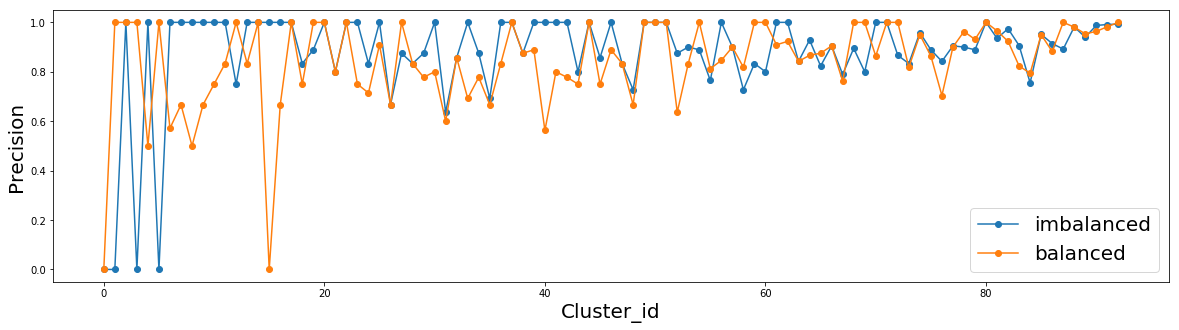

In [228]:
plt.figure(figsize=(20,5))
plt.plot([imb_precision[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="imbalanced", marker='o')
plt.plot([b_precision[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="balanced", marker='o')
plt.xlabel("Cluster_id", fontsize=20)
plt.ylabel("Precision", fontsize=20)
plt.legend(fontsize=20)

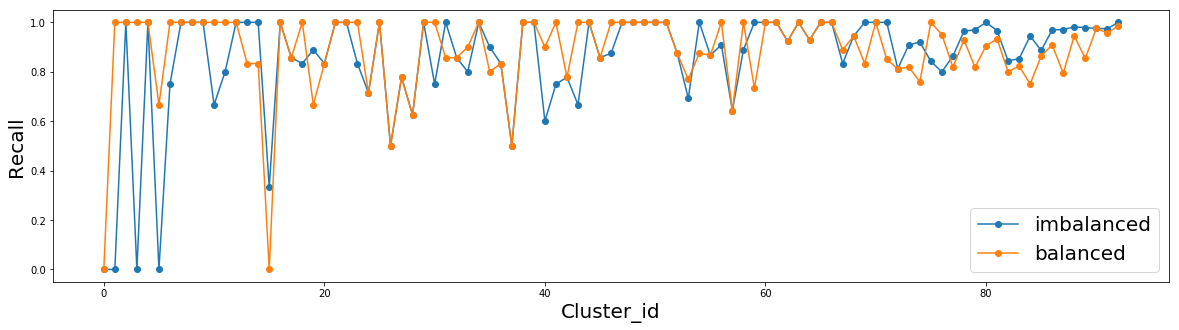

In [229]:
plt.figure(figsize=(20,5))
plt.plot([imb_recall[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="imbalanced", marker='o')
plt.plot([b_recall[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="balanced", marker='o')
plt.xlabel("Cluster_id", fontsize=20)
plt.ylabel("Recall", fontsize=20)
plt.legend(fontsize=20)

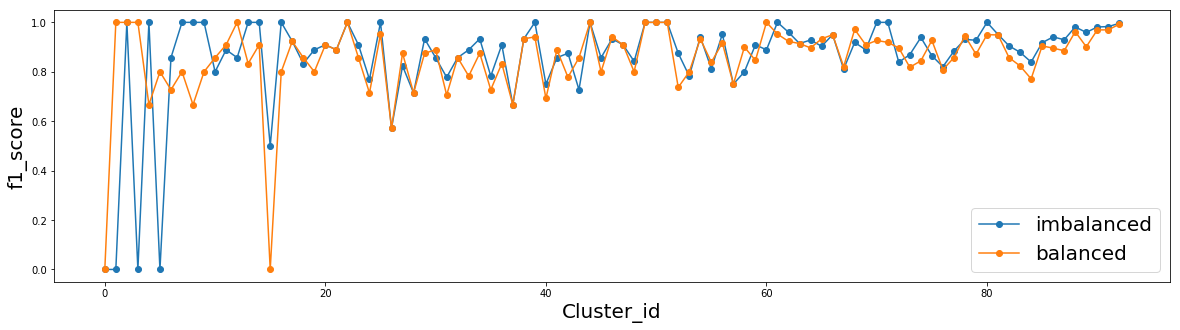

In [230]:
plt.figure(figsize=(20,5))
plt.plot([imb_f1_score[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="imbalanced", marker='o')
plt.plot([b_f1_score[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="balanced", marker='o')
plt.xlabel("Cluster_id", fontsize=20)
plt.ylabel("f1_score", fontsize=20)
plt.legend(fontsize=20)

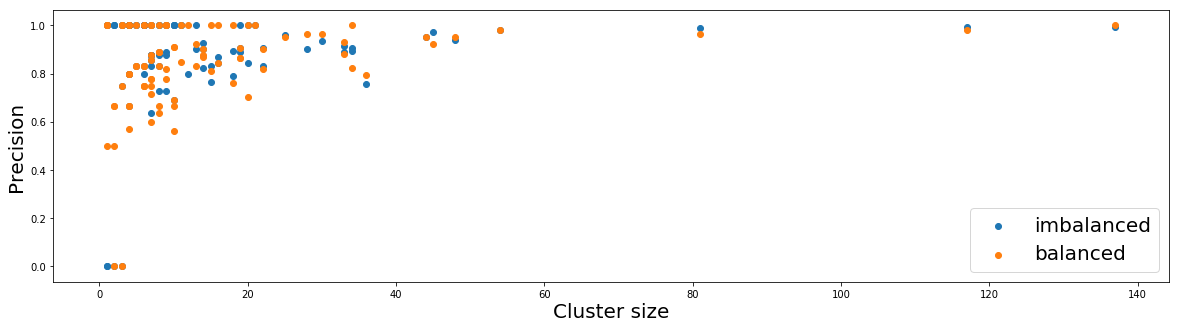

In [148]:
plt.figure(figsize=(20,5))
plt.scatter(sorted_V1_cl_size ,[imb_precision[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="imbalanced", marker='o')
plt.scatter(sorted_V1_cl_size , [b_precision[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="balanced", marker='o')
plt.xlabel("Cluster size", fontsize=20)
plt.ylabel("Precision", fontsize=20)
plt.legend(fontsize=20)

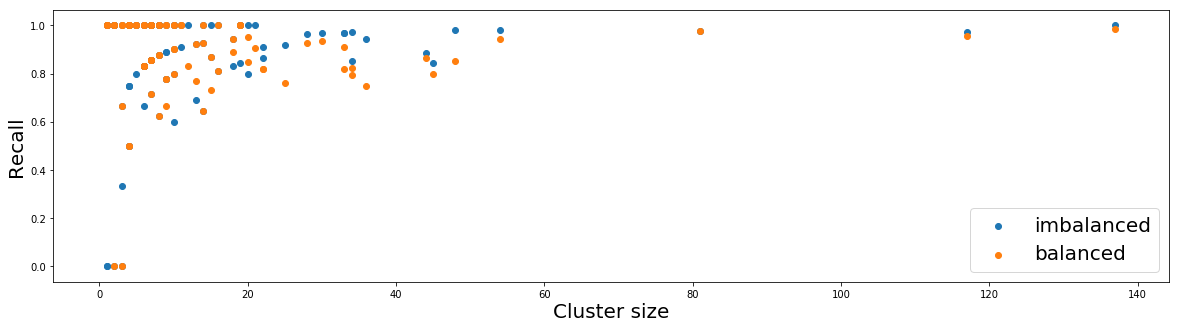

In [149]:
plt.figure(figsize=(20,5))
plt.scatter(sorted_V1_cl_size ,[imb_recall[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="imbalanced", marker='o')
plt.scatter(sorted_V1_cl_size , [b_recall[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="balanced", marker='o')
plt.xlabel("Cluster size", fontsize=20)
plt.ylabel("Recall", fontsize=20)
plt.legend(fontsize=20)

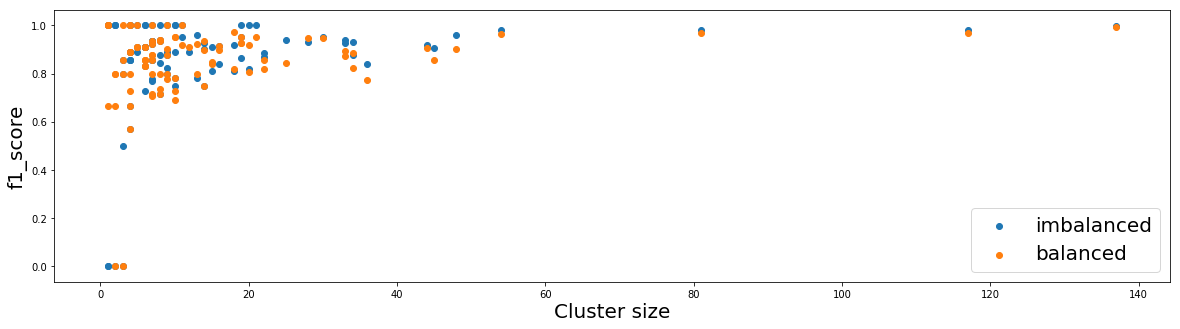

In [150]:
plt.figure(figsize=(20,5))
plt.scatter(sorted_V1_cl_size ,[imb_f1_score[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="imbalanced", marker='o')
plt.scatter(sorted_V1_cl_size , [b_f1_score[i] for i in [i.replace(" ", "_") for i in sorted_V1_cl]], label="balanced", marker='o')
plt.xlabel("Cluster size", fontsize=20)
plt.ylabel("f1_score", fontsize=20)
plt.legend(fontsize=20)

In [371]:
# path = my_computer_folder + "patchseq_norm.csv"
# Patchseq_data = read_data(path)
# path = my_computer_folder + "patchseq_correct_labels.csv"
# Patchseq_labels = read_labels(path, V1_cl)
# patchseq_cells = Patchseq_data.index.tolist() 